
******************************************************************** 
 http-1.log INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807537 entries, 0 to 807536
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ts                807537 non-null  datetime64[ns]
 1   id_orig_h         807537 non-null  object        
 2   id_resp_p         807537 non-null  int64         
 3   request_body_len  807537 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 24.6+ MB
None

******************************************************************** 
 train_DF
                               ts      id_orig_h  id_resp_p  request_body_len
0      2012-05-30 19:09:27.177343  192.168.88.10         80                 0
1      2012-05-30 19:09:28.343725  192.168.88.10         80                 0
2      2012-05-30 19:09:29.124170  192.168.88.10         80                 0
3   

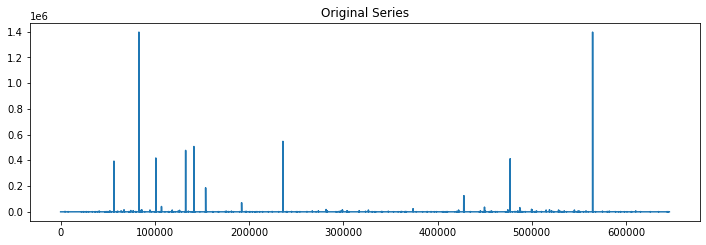


******************************************************************** 
 Plot Partial Autocorrelation


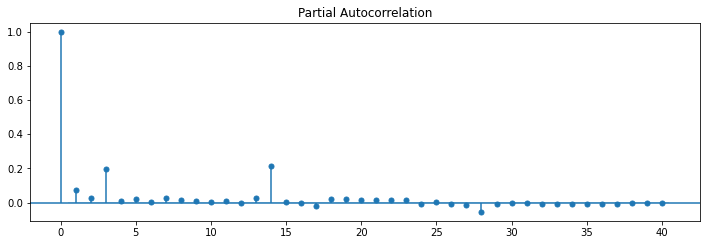


******************************************************************** 
 Plot Autocorrelation


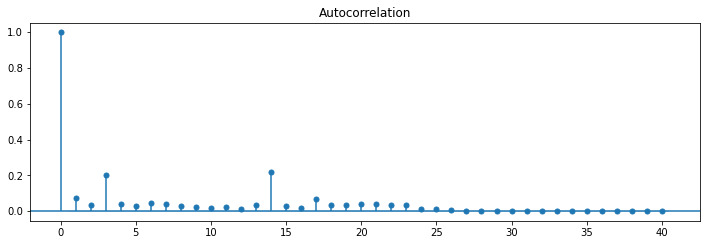


******************************************************************** 
 Classical Inference

 classical: MLE
Normal ARIMA(1,0,6)                                                                                       
======================================================= ==================================================
Dependent Variable: request_body_len                    Method: MLE                                       
Start Date: 646035                                      Log Likelihood: -1353210.0652                     
End Date: 807536                                        AIC: 2706438.1304                                 
Number of observations: 161502                          BIC: 2706528.0609                                 
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                           

        request_body_len
807537         -7.046155
807538         -2.261159
807539         13.186782
807540          9.449087
807541         -2.931005
...                  ...
807632          2.561544
807633          4.640314
807634          6.896969
807635         -6.283009
807636         20.277465

[100 rows x 1 columns]

Tiempo del proceso ---> 45.0088

******************************************************************** 
 Forecast exec times
          model_type     time  forecast_mean_request_body_len
0     classical: MLE   0.5450                        6.460586
1     classical: PML   0.5503                        6.460572
2  bayesian: Laplace   0.6027                        6.460572
3      bayesian: M-H  45.0088                        3.037051


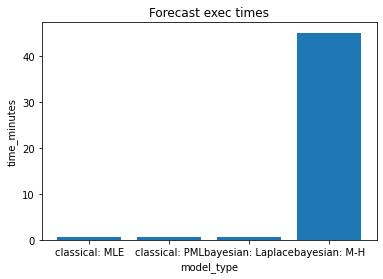

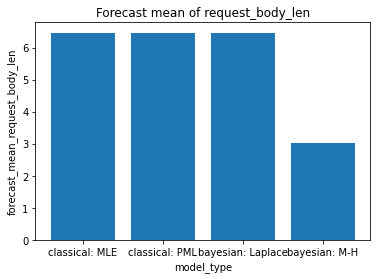


GENERAL TIME ---> 50.061166666666665m


In [1]:
from time import time
from os import listdir
from datetime import datetime as dt
from termcolor import  colored
from pandas import read_parquet, read_csv, DataFrame, concat
from modules import run_arima as ra
from modules import arima_utils as au

div = colored('\n********************************************************************','green')

def log_to_parquet(in_file: str, out_file: str, file_cols: list, parquet_engine: str):
    # LOAD DATA FROM A LOG FILE AND SAVE IT ON A PARQUET FILE TO IMPROVE PERFORMANCE AT READING THE DATA
    df = read_csv(in_file, sep="\t", header=None,
                  names=file_cols, low_memory=False)
    df.to_parquet(out_file, index=False, engine=parquet_engine)
    del df


def get_files_inFolder(folder: str, fileType: str):
    return list(filter(lambda fileName: 
                            fileName[-len(fileType):] == fileType,
                        listdir(folder)))


def slice_dataFrame(df: DataFrame, slice_size: float):
    idx_cut = int((df.shape[0])*(1-slice_size))
    return df.iloc[:idx_cut], df.iloc[idx_cut:]


def an_detect(http_log_name: str, train: bool):
    P_ENGINE = "pyarrow"
    cols_log = ['ts', 'uid', 'id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p',
                'trans_depth', 'method', 'host', 'uri', 'referrer', 'user_agent',
                'request_body_len', 'response_body_len', 'status_code', 'status_msg',
                'info_code', 'info_msg', 'filename', 'tags', 'username',
                'password', 'proxied', 'orig_fuids', 'orig_mime_types', 'resp_fuids',
                'resp_mime_types']
    list_parq_files = get_files_inFolder("./","parq")
    http_parq_name = (http_log_name.split('.')[0])+".parq"
    if not http_parq_name in list_parq_files:
        log_to_parquet(http_log_name, http_parq_name, cols_log, P_ENGINE)
    
    important_cols = ["ts","id_orig_h", "id_resp_p", "request_body_len"]
    df = read_parquet(http_parq_name, columns=important_cols)
    df["ts"] = list(map(
                    lambda date: 
                        dt.fromtimestamp(float(date)),
                    df["ts"].tolist()))
    print(div,colored('\n '+http_log_name+' INFO','green'))
    print(df.info())

    TEST_SIZE = 0.2
    train_df, test_df = slice_dataFrame(df,TEST_SIZE)
    print(div,colored('\n train_DF','green'))
    print(train_df)

    print(div,colored('\n test_DF','green'))
    print(test_df)

    t_col = "request_body_len"
    if train:
        print(div,colored('\n Training...','green'))
        ra.get_pacf_acf(train_df, t_col)

    ra.set_up(test_df, 1, 6, t_col)

    print(div, colored('\n Classical Inference', 'green'))
    t_classical = ra.try_models(inference='classical', h=100, pv=40)

    print(div, colored('\n Bayesian Inference', 'green'))
    t_bayesian = ra.try_models(inference='bayesian', h=100, pv=40)
    
    all_exec_times = concat([t_classical, t_bayesian], ignore_index=True)
    print(div,colored('\n Forecast exec times','green'))
    print(all_exec_times)
    au.plot(
        x= all_exec_times['model_type'].tolist(),
        y= all_exec_times['time'].tolist(),
        title= 'Forecast exec times',
        xlabel= 'model_type',
        ylabel= 'time_minutes'
    )
    au.plot(
        x= all_exec_times['model_type'].tolist(),
        y= all_exec_times['forecast_mean_'+t_col].tolist(),
        title= 'Forecast mean of '+t_col,
        xlabel= 'model_type',
        ylabel= 'forecast_mean_'+t_col
    )
    


def main():
    paths = {
        "http":"http-1.log"
    }

    intiTime = time()

    an_detect(http_log_name=paths["http"], train=True)
    # an_detect(http_log_name=paths["http"], train=False)

    elapsedTime = round(time()-intiTime, 2)
    elapsedTime = str(elapsedTime/60) + \
        "m" if elapsedTime >= 60 else str(elapsedTime)+"s"
    print("\nGENERAL TIME --->", elapsedTime)


main()
